In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd

In [25]:
import datetime as dt
from datetime import timedelta, datetime
from dateutil.relativedelta import relativedelta

# Reflect Tables into SQLAlchemy ORM

In [26]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, and_
from sqlalchemy import desc

In [27]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [28]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [29]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [30]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [31]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Climate Analysis

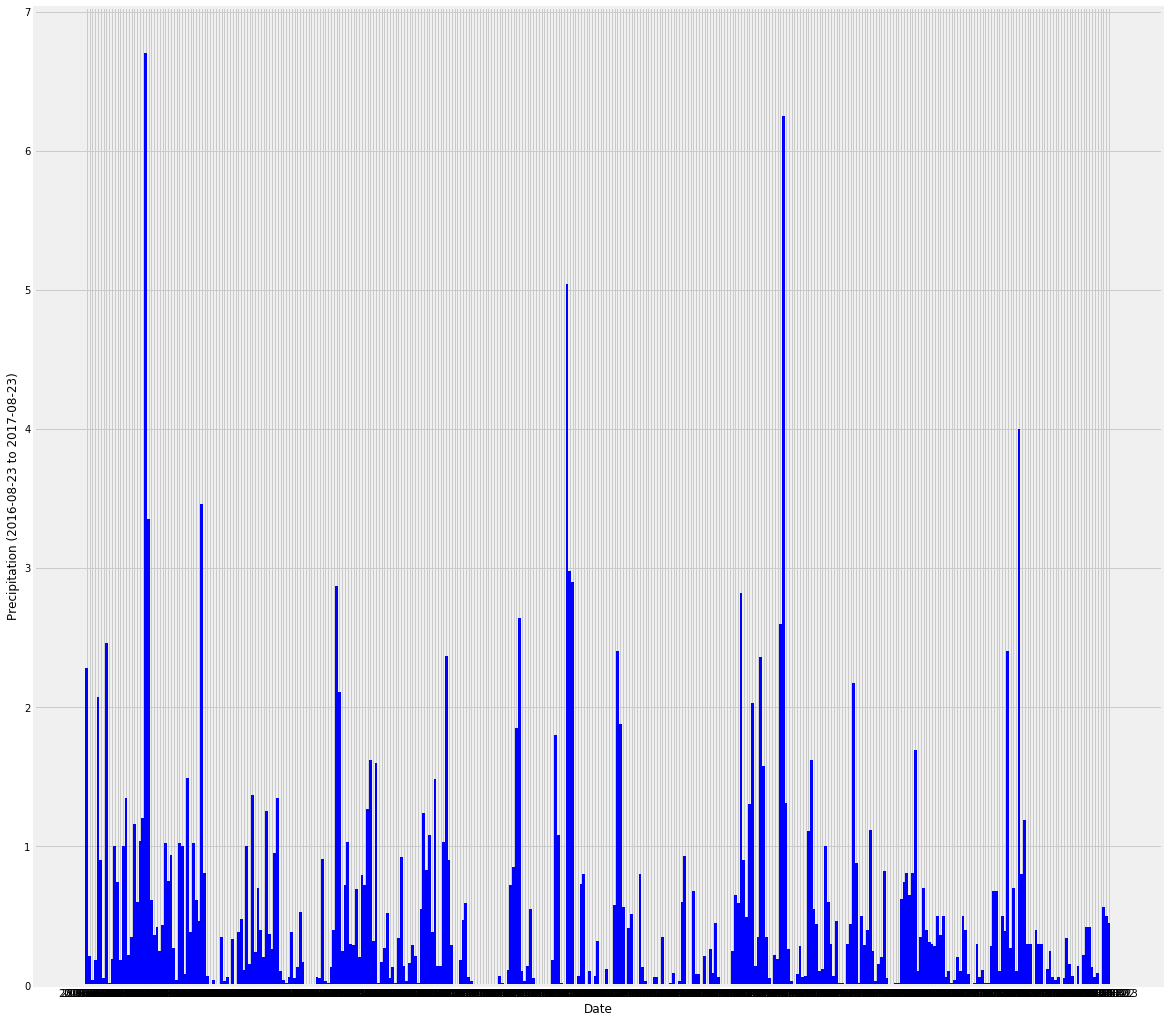

In [32]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results
date = []
for _ in session.query(Measurement.date).order_by(Measurement.date.desc()):
    date.append(_.date)

# Calculate the date 1 year ago from the last data point in the database
last_date = date[1]
one_year_ago = datetime.fromisoformat(last_date) - relativedelta(years=1)
one_year_ago

# Perform a query to retrieve the data and precipitation scores
data = session.query(Measurement).\
    filter(Measurement.date >= one_year_ago)

data_dict = dict()
station = []
date = []
prcp = []
tobs = []
for _ in data:
    station.append(_.station)
    date.append(_.date)
    prcp.append(_.prcp)
    tobs.append(_.tobs)
    
data_dict["station"] = station
data_dict["date"] = date
data_dict["prcp"] = prcp
data_dict["tobs"] = tobs

# Save the query results as a Pandas DataFrame and set the index to the date column
data_df = pd.DataFrame(data_dict).set_index("date")

# Sort the dataframe by date
data_df = data_df.sort_index()
data_df

# Use Pandas Plotting with Matplotlib to plot the data
plt.figure(figsize=(18,18))
plt.bar(data_df.index.values,data_df["prcp"], color='b', align="center", width=1)
plt.xlabel("Date")
plt.ylabel("Precipitation (2016-08-23 to 2017-08-23)")

plt.show()

![precipitation](Images/precipitation.png)

In [33]:
# Use Pandas to calcualte the summary statistics for the precipitation data
data_df["prcp"].describe()

count    2015.000000
mean        0.176462
std         0.460288
min         0.000000
25%         0.000000
50%         0.020000
75%         0.130000
max         6.700000
Name: prcp, dtype: float64

![describe](Images/describe.png)

In [35]:
# Design a query to show how many stations are available in this dataset?
session.query(Measurement).group_by(Measurement.station).count()

9

In [38]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.
active_stations = session.query(Measurement.station, \
            func.count(Measurement.station)).\
            group_by(Measurement.station).order_by(func.count(Measurement.station).desc()).\
            all()

In [39]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature of the most active station?
max_temp = session.query(Measurement.station, \
            func.max(Measurement.tobs)).\
            filter(Measurement.station == active_stations[0][0]).\
            all()
min_temp = max_temp = session.query(Measurement.station, \
            func.min(Measurement.tobs)).\
            filter(Measurement.station == active_stations[0][0]).\
            all()
avg_temp = session.query(Measurement.station, \
            func.avg(Measurement.tobs)).\
            filter(Measurement.station == active_stations[0][0]).\
            all()
calculations = [max_temp[0][1], min_temp[0][1], avg_temp[0][1]]
calculations

[54.0, 54.0, 71.66378066378067]

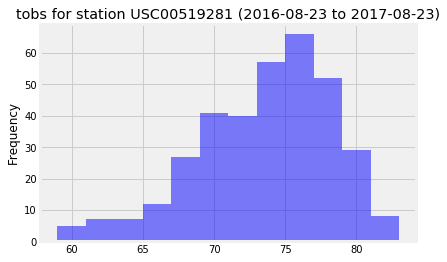

In [40]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
station_temp = session.query(Measurement.station, \
            func.count(Measurement.tobs)).\
            group_by(Measurement.station).order_by(func.count(Measurement.tobs).desc()).\
            all()
temp_df = data_df.loc[data_df["station"]==station_temp[0][0]]
temp_df

n_bins = 12
plt.hist(temp_df["tobs"], color='b', alpha= 0.5, bins=n_bins)
plt.ylabel("Frequency")
plt.title(f"tobs for station {station_temp[0][0]} (2016-08-23 to 2017-08-23)")
plt.show()

![precipitation](Images/station-histogram.png)

In [41]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [42]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.
print(calc_temps('2017-03-25', '2017-03-30'))

[(68.0, 74.83333333333333, 80.0)]


Text(0.5, 1.0, 'Trip Avg Temp')

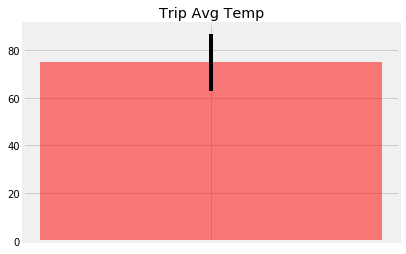

In [43]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)
calc = calc_temps('2017-03-25', '2017-03-30')
yerr = calc[0][2]- calc[0][0]
x_axis= [""]
plt.bar(x_axis, calc[0][1], yerr=calc[0][2]- calc[0][0], color="r",alpha =0.5)
plt.title("Trip Avg Temp")

In [44]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation
session.query(Measurement.station, Station.name, \
            Station.latitude, Station.longitude, \
            Station.elevation,\
            func.sum(Measurement.prcp)).\
            group_by(Measurement.station).\
            order_by(func.sum(Measurement.prcp).desc()).\
            join(Station, Measurement.station == Station.station).\
            filter(Measurement.date <= '2017-03-30').filter(Measurement.date >= '2011-03-25').\
            all()


[('USC00516128',
  'MANOA LYON ARBO 785.2, HI US',
  21.3331,
  -157.8025,
  152.4,
  861.309999999998),
 ('USC00519281',
  'WAIHEE 837.5, HI US',
  21.45167,
  -157.84888999999998,
  32.9,
  464.7199999999986),
 ('USC00513117',
  'KANEOHE 838.1, HI US',
  21.4234,
  -157.8015,
  14.6,
  299.28000000000026),
 ('USC00519523',
  'WAIMANALO EXPERIMENTAL FARM, HI US',
  21.33556,
  -157.71139,
  19.5,
  229.23000000000002),
 ('USC00514830',
  'KUALOA RANCH HEADQUARTERS 886.9, HI US',
  21.5213,
  -157.8374,
  7.0,
  181.11000000000013),
 ('USC00519397',
  'WAIKIKI 717.2, HI US',
  21.2716,
  -157.8168,
  3.0,
  109.93000000000026),
 ('USC00511918',
  'HONOLULU OBSERVATORY 702.2, HI US',
  21.3152,
  -157.9992,
  0.9,
  62.970000000000006),
 ('USC00517948',
  'PEARL CITY, HI US',
  21.3934,
  -157.9751,
  11.9,
  35.440000000000005),
 ('USC00518838',
  'UPPER WAHIAWA 874.3, HI US',
  21.4992,
  -158.0111,
  306.6,
  22.29000000000001)]

## Optional Challenge Assignment

In [45]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

[(62.0, 69.15384615384616, 77.0)]

In [61]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`
normals = []
    
# Set the start and end date of the trip
start_date = datetime(year=2018,month=3, day=25)
end_date = datetime(year=2018,month=3, day=30)

# Use the start and end date to create a range of dates
delta = end_date - start_date

# Stip off the year and save a list of %m-%d strings
travel_dates = []
for i in range(delta.days + 1):
    day = start_date + timedelta(days=i)
    day = str(day)[5:-9]
    travel_dates.append(day)

# Loop through the list of %m-%d strings and calculate the normals for each date
for date in travel_dates:
    normals.append(daily_normals(date))
normals

[[(63.0, 71.5, 78.0)],
 [(64.0, 71.38, 80.0)],
 [(63.0, 71.53846153846153, 80.0)],
 [(59.0, 71.51785714285714, 82.0)],
 [(58.0, 71.35714285714286, 77.0)],
 [(62.0, 72.17543859649123, 79.0)]]

In [73]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index
trip_dict=dict()
dates = []
tmin = []
tmax = []
tavg = []
for i in range(len(travel_dates)):
    dates.append("2018-"+travel_dates[i])
    tmin.append(normals[i][0][0])
    tmax.append(normals[i][0][2])
    tavg.append(normals[i][0][1])
trip_dict["date"] = dates
trip_dict["tmin"] = tmin
trip_dict["tavg"] = tavg
trip_dict["tmax"] = tmax
trip = pd.DataFrame(trip_dict)

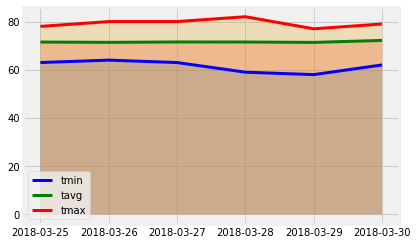

In [83]:
# Plot the daily normals as an area plot with `stacked=False`
x = trip["date"]
# , trip["tavg"], trip["tmax"]]
fig, ax = plt.subplots()
ax.plot(x, trip["tmin"], color="b", lw=3)
ax.fill_between(x, 0, trip["tmin"], alpha=.3)
ax.plot(x, trip["tavg"], color="g", lw=3)
ax.fill_between(x, 0, trip["tavg"], alpha=.3)
ax.plot(x, trip["tmax"], color="r", lw=3)
ax.fill_between(x, 0, trip["tmax"], alpha=.3)

plt.legend(["tmin", "tavg", "tmax"])